# Author details and requirements

**Author**: Daniel Hortelano Roig</br>
**Organisation**: University of Oxford, UK</br>
**Contact**: daniel.hortelanoroig@gmail.com</br>
**Date**: December 2024

The [dd2dpy
](https://github.com/dhortela/dd2dpy/) package is required to run this notebook. This notebook is also available on Google Colab via [link](https://colab.research.google.com/drive/1i0TPtc9gJwDNPm9BSH155uJEfJ6Mcp9J#scrollTo=CCE3IMWKpmKG).

# Importing simulation code

## Libraries used for session

In [1]:
# Install and import libraries necessary for this session

import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import pylabdd as dd

ERROR:root:An exception has occurred while importing fortran module: No module named 'PK_force'
Using Python subroutines for PK force.


## Helper functions

In [2]:
def calc_plastic_strain_increment(rho_m,b0,dx,bx,dy,by):
  Cpl = rho_m*b0 # prefactor for Orowan law
  dgpl = Cpl*(np.dot(dx,bx) + np.dot(dy,by))
  return dgpl

def plot_dislocations(x,y,sp_inc,dx,dy,flag,LX,LY,arrowson=True):
  assert x.size == y.size == sp_inc.size == dx.size == dy.size == flag.size
  N = x.size
  qx = np.cos(sp_inc)
  qy = np.sin(sp_inc)
  for i in range(N):
    if flag[i] == 0:
      if arrowson == True:
        plt.quiver(x[i],y[i], qx[i]/2, qy[i]/2, color='black', headaxislength=0,\
                   headlength=0, scale=3, \
    linewidth=.5, units='xy', width=.05, headwidth=1)
        plt.quiver(x[i],y[i], -qx[i]/2, -qy[i]/2, color='black', headaxislength=0,\
                   headlength=0, scale=3, \
    linewidth=.5, units='xy', width=.05, headwidth=1)
        plt.quiver(x[i],y[i], -qy[i]/2, qx[i]/2, color='black', headaxislength=0,\
                   headlength=0, scale=3, \
    linewidth=.5, units='xy', width=.05, headwidth=1)
      else:
        plt.scatter(x[i],y[i], marker=(3, 0, sp_inc[i]*180/np.pi), s=60, c='blue')
      # plt.quiver(x[i],y[i], dx[i], dy[i], color='magenta')
    elif flag[i] == 1:
      plt.scatter(x[i],y[i], marker='o', s=10, c='red')
      #plt.quiver(x[i],y[i], qx[i], qy[i], color='green')
      #plt.quiver(x[i],y[i], dx[i], dy[i], color='magenta')
  ax = plt.gca()
  ax.set_xlabel(r'x ($\mu$m)',fontsize=14)
  ax.set_ylabel(r'y ($\mu$m)',fontsize=14)
  ax.set_xlim(0, LX)
  ax.set_ylim(0, LY)
  ax.set_aspect('equal')

# Session 3

First we must define the parameters which describe the material. This includes the shear modulus and the Poisson's ratio. In these sessions you will work with **Zirconium** as an example.

In [3]:
# Define material parameters for Zirconium

mu = 37.1e3                 # Shear modulus
nu = 0.32                   # Poisson ratio

## A stress-strain simulation

We shall now run a simulation which involves Frank-Read sources. In addition, dislocations may exit the domain which removes them completely from the simulation.

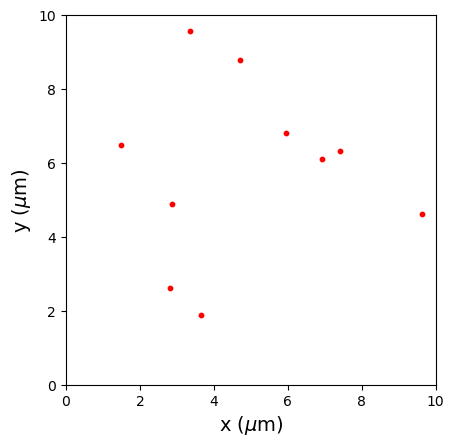

In [4]:
# Strength of dislocations:
b0 = 3.233e-4

# Size of the rectangular domain:
LX = 10
LY = 10

# Total number of dislocations to create:
Nm = 0

# Total number of sources to create:
Ns = 10

# Total number of dislocation-type objects:
Ntot = Nm + Ns

# Generate random positions somewhere inside the rectangular domain:
# np.random.rand(Ntot) : Array of length Ntot where each entry is a number from 0 to 1
xpos = LX * np.random.rand(Ntot)
ypos = LY * np.random.rand(Ntot)

# Define the slip plane angles of the dislocations and sources:
spi1 = 0

# Set boundary conditions:
bc = 'pbc' # Periodic boundary conditions
# Can set bc = 'pbc', bc = 'finite', or bc = 'fixed'

# Mobility coefficient: how fast dislocations move (higher = faster)
dmob = 0.01

# Source activation strength:
ctau = 30.
#ctau = 110.

# Dislocation positions:
xpos = LX * np.random.rand(Ntot)
ypos = LY * np.random.rand(Ntot)

ssd = dd.Dislocations(Nm=Nm, Ns=Ns, mu=mu, nu=nu, b0=b0, spi1=spi1, \
                          xpos=xpos, ypos=ypos, LX=LX, LY=LY, \
                          dmob=dmob, bc=bc, \
                          ctau=ctau)

# Set strain parameters

edot = 1.e-4             # Strain rate (per microsecond)
efin = 1.e-2             # Final strain

plot_dislocations(ssd.xpos,ssd.ypos,ssd.sp_inc,ssd.dx,ssd.dy,ssd.flag,LX,LY,arrowson=True)
#ssd.plot_stress_simple(arrowson=True)

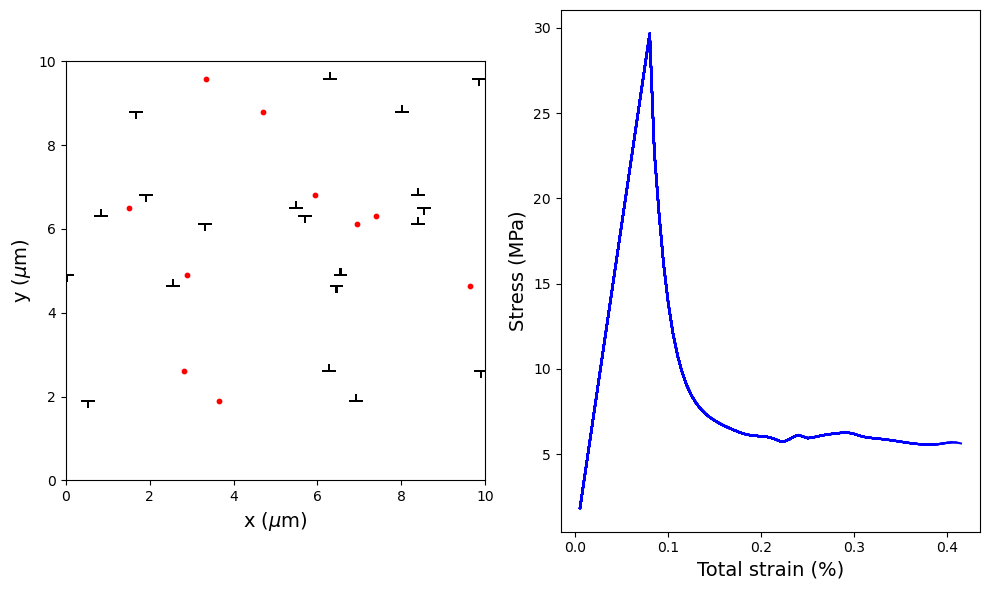

8300 : sigma = 5.62554E+00 | etot = 4.14950E-03  | epl = 3.99838E-03 | Total time = 4.15000E+01 | Nmob = 20


In [ ]:
totalSimTime = efin/edot

# Initialise variables

simTime = 0. # Current simulation time
sig = 0.  # Macro (elastic) shear stress
epl  = 0. # Plastic shear strain
etot = 0. # Total shear strain
ic = 0    # Iteration
icp = 0   # Plot iteration
dt = ssd.dt0 # Current time-step

# Saving and plotting frequencies:
saveFreq = 100
plotFreq = 100

# Storage for post-processing

t = np.array([]) # Total time array
epl_np = np.array([]) # Plastic shear strain array
sig_np = np.array([]) # Total shear stress
etot_np = np.array([]) # Total shear strain
rho_np = np.array([]) # Mobile dislocation density

#fig = plt.figure(figsize=(6,6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

while simTime < totalSimTime:

  # If there are no dislocations, end simulation:
  if ssd.Ntot <= 0:
      break

  # Increase total plastic strain linearly with time:
  etot = edot * simTime

  # Calculate elastic strain:
  eel = etot - epl

  # Calculate elastic shear stress using Hooke's law:
  sig = mu * eel

  # Run one time-step in simulation:
  fsp, dt = ssd.move_disl(sig, 'viscous', dt)

  # Calculate plastic slip
  epl += calc_plastic_strain_increment( \
    ssd.rho_m,ssd.b0,ssd.dx,ssd.bx,ssd.dy,ssd.by)

  # Increment time:
  simTime += dt

  # Increment time-step iteration:
  ic += 1

  # Save data to array every saveFreq steps:
  if ic % saveFreq == 0:

    sig_np = np.append(sig_np,sig)
    etot_np = np.append(etot_np,etot)

  # Plot data every plotFreq steps:
  if ic % plotFreq == 0:

    icp = ic

    display.clear_output(wait=True)

    plt.sca(ax1)
    ax1.cla()
    plot_dislocations(ssd.xpos,ssd.ypos,ssd.sp_inc,ssd.dx,ssd.dy,ssd.flag,LX,LY)

    plt.sca(ax2)
    ax2.plot(etot_np*100,sig_np,'b')
    ax2.set_xlabel('Total strain (%)',fontsize=14)
    ax2.set_ylabel('Stress (MPa)',fontsize=14)

    fig.tight_layout()

    display.display(plt.gcf())

    print(ic,': sigma =', '%.5E' % sig,'| etot =','%.5E' % etot,' | epl =','%.5E' % epl,'| Total time =','%.5E' % simTime,'| Nmob =','%d' % ssd.Nmob)

display.clear_output(wait=True)
plt.sca(ax1)
ax1.cla()
plot_dislocations(ssd.xpos,ssd.ypos,ssd.sp_inc,ssd.dx,ssd.dy,ssd.flag,LX,LY)

plt.sca(ax2)
ax2.plot(etot_np*100,sig_np,'b')
ax2.set_xlabel('Total strain (%)',fontsize=14)
ax2.set_ylabel('Stress (MPa)',fontsize=14)

fig.tight_layout()
print(ic,': sigma =', '%.5E' % sig,'| etot =','%.5E' % etot,' | epl =','%.5E' % epl,'| Total time =','%.5E' % simTime,'| Nmob =','%d' % ssd.Nmob)

# Some sample code for you



```
# Basic example creation of a dislocation configuration:
dd = dd.Dislocations(Nm=Nm, Ns=Ns, mu=mu, nu=nu, b0=b0, spi1=spi1, \
                          xpos=xpos, ypos=ypos, LX=LX, LY=LY, \
                          dmob=dmob, bc=bc, \
                          ctau=ctau)

# Variables
dd.Nmob # Number of mobile dislocations
dd.rho_m # Density of mobile dislocations
dd.sp_inc # Slip plane angles of each dislocation -- always an array
dd.xpos # x-positions -- array in general
dd.ypos # y-positions -- array in general

# Functions (shown inputs are the defaults)
dd.plot_stress_simple(arrowson=True)

plot_dislocations(dd.xpos,dd.ypos,dd.sp_inc, \
            dd.dx,dd.dy,dd.flag,LX,LY,arrowson=True)
```

